In [2]:
import ase
import time
import sys
import torch
from torch.nn import MSELoss
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from skorch.callbacks import Checkpoint, EpochScoring
from skorch.callbacks.lr_scheduler import LRScheduler
from amptorch.gaussian import SNN_Gaussian
from amptorch.model import FullNN, CustomLoss, TanhLoss
from amptorch.data_preprocess import AtomsDataset, factorize_data, collate_amp, TestDataset
from md_work.md_utils import md_run, calculate_energies, calculate_forces, time_plots, kde_plots
from amptorch.skorch_model import AMP
from amptorch.skorch_model.utils import target_extractor, energy_score, forces_score
from amptorch.lj_model import lj_optim
from torch.utils.data import DataLoader
from torch.nn import init
from skorch.utils import to_numpy
import numpy as np
from ase import Atoms, units
from ase.calculators.emt import EMT
import matplotlib.pyplot as plt

import skorch.callbacks.base
class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./results/checkpoints/forces_best_params.pt')

In [6]:
# Define Training data
label = "COCu_ML_lang_hook_300K"
# 100 images extracted from an MD simulation recording every 20th time step (2000fs total)
images = ase.io.read("../datasets/COCu_lang_hook_300K.traj", ":2000:20")

# define symmetry functions to be used
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276 #EMT asap_cutoff: False

forcetraining = True
training_data = AtomsDataset(images, SNN_Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=10, lj_data=None)
unique_atoms = training_data.elements
fp_length = training_data.fp_length
device = "cpu"

Calculating fingerprints...
Fingerprints Calculated!


In [15]:
LR_schedule = LRScheduler('CosineAnnealingLR', T_max=5)
cp = Checkpoint(monitor='forces_score_best', fn_prefix='./results/checkpoints/forces_best_')
load_best_valid_loss = train_end_load_best_valid_loss()

net = NeuralNetRegressor(
    module=FullNN(unique_atoms, [fp_length, 3, 60], device, forcetraining=forcetraining),
    criterion=CustomLoss,
    criterion__force_coefficient=0.04,
    optimizer=torch.optim.Adam,
    lr=1e-2,
    batch_size=10,
    max_epochs=2000,
    iterator_train__collate_fn=collate_amp,
    iterator_train__shuffle=True,
    iterator_valid__collate_fn=collate_amp,
    iterator_valid__shuffle=False,
    device=device,
    train_split= CVSplit(cv=5, random_state=1),
    callbacks=[
        EpochScoring(
            forces_score,
            on_train=False,
            use_caching=True,
            target_extractor=target_extractor,
        ),
        EpochScoring(
            energy_score,
            on_train=False,
            use_caching=True,
            target_extractor=target_extractor,
        ), cp,  load_best_valid_loss, LR_schedule
    ],
)

In [16]:
# Define calculator and train
calc = AMP(training_data, net, label=label)
calc.train(overwrite=True)

  epoch    energy_score    forces_score    train_loss    valid_loss    cp     dur
-------  --------------  --------------  ------------  ------------  ----  ------
      1          0.1042          0.2667        5.4446        3.3559     +  0.2991
      2          0.0329          0.2683        1.5675        0.9710        0.3429
      3          0.0562          0.2655        0.9664        1.4628     +  0.5715
      4          0.0151          0.2658        0.7577        0.7479        0.5515
      5          0.0181          0.2639        0.6895        0.7620     +  0.3100
      6          0.0229          0.2630        0.6321        0.8065     +  0.3094
      7          0.0229          0.2630        0.6242        0.8065        0.3054
      8          0.0248          0.2623        0.6225        0.8249     +  0.3050
      9          0.0257          0.2610        0.6194        0.8291     +  0.5598
     10          0.0254          0.2598        0.6109        0.8197     +  0.5619
     11         

     91          0.0243          0.2626        0.5347        0.8201        0.3419
     92          0.0150          0.2644        0.5427        0.7400        0.3011
     93          0.0211          0.2650        0.5310        0.7973        0.2931
     94          0.0168          0.2653        0.5243        0.7585        0.3023
     95          0.0170          0.2658        0.5219        0.7634        0.3161
     96          0.0195          0.2651        0.5172        0.7818        0.2940
     97          0.0195          0.2651        0.5158        0.7818        0.3049
     98          0.0179          0.2650        0.5165        0.7660        0.2933
     99          0.0148          0.2642        0.5207        0.7377        0.2954
    100          0.0235          0.2656        0.5235        0.8267        0.3023
    101          0.0175          0.2658        0.5285        0.7669        0.3288
    102          0.0215          0.2650        0.5287        0.8013        0.2935
    103         

    189          0.0234          0.2682        0.4630        0.8386        0.6994
    190          0.0220          0.2678        0.4630        0.8214        0.6529
    191          0.0236          0.2687        0.4665        0.8439        0.6150
    192          0.0261          0.2676        0.4682        0.8687        0.6112
    193          0.0186          0.2702        0.4784        0.7997        0.6017
    194          0.0230          0.2697        0.4744        0.8427        0.6209
    195          0.0216          0.2708        0.4683        0.8324        0.5452
    196          0.0246          0.2705        0.4620        0.8649        0.5471
    197          0.0246          0.2705        0.4595        0.8649        0.5864
    198          0.0238          0.2699        0.4593        0.8518        0.6198
    199          0.0250          0.2693        0.4622        0.8641        0.3002
    200          0.0212          0.2697        0.4686        0.8226        0.3068
    201         

    287          0.0276          0.2725        0.4156        0.9143        0.2936
    288          0.0308          0.2737        0.4167        0.9667        0.2952
    289          0.0277          0.2747        0.4223        0.9273        0.2929
    290          0.0383          0.2762        0.4273        1.1059        0.2919
    291          0.0350          0.2713        0.4251        1.0210        0.2941
    292          0.0395          0.2748        0.4501        1.1226        0.2937
    293          0.0412          0.2734        0.4527        1.1476        0.2906
    294          0.0248          0.2737        0.4476        0.8845        0.3046
    295          0.0267          0.2746        0.4341        0.9126        0.2919
    296          0.0358          0.2753        0.4207        1.0562        0.3007
    297          0.0358          0.2753        0.4152        1.0562        0.2949
    298          0.0319          0.2751        0.4202        0.9913        0.2945
    299         

    385          0.0369          0.2918        0.3796        1.1680        0.6052
    386          0.0363          0.2909        0.3648        1.1519        0.5729
    387          0.0363          0.2909        0.3561        1.1519        0.5640
    388          0.0375          0.2901        0.3538        1.1700        0.3215
    389          0.0384          0.2878        0.3570        1.1736        0.5737
    390          0.0351          0.2896        0.3592        1.1238        0.5889
    391          0.0352          0.2851        0.3707        1.0990        0.2955
    392          0.0326          0.2908        0.3776        1.0890        0.2959
    393          0.0347          0.2813        0.3857        1.0699        0.6558
    394          0.0358          0.2884        0.3711        1.1287        0.6521
    395          0.0349          0.2854        0.3622        1.0953        0.6339
    396          0.0354          0.2876        0.3546        1.1166        0.5541
    397         

    484          0.0381          0.3049        0.3740        1.2655        0.5453
    485          0.0384          0.2972        0.3430        1.2272        0.5423
    486          0.0358          0.2996        0.3195        1.1939        0.5413
    487          0.0358          0.2996        0.3121        1.1939        0.5470
    488          0.0349          0.3022        0.3102        1.1939        0.5484
    489          0.0346          0.3045        0.3100        1.2015        0.5459
    490          0.0390          0.3125        0.3136        1.3296        0.5474
    491          0.0250          0.3093        0.3299        1.0908        0.5467
    492          0.0608          0.3070        0.3710        1.8290        0.5466
    493          0.0390          0.3159        0.4059        1.3501        0.5454
    494          0.0383          0.3026        0.3501        1.2561        0.5477
    495          0.0339          0.3091        0.3328        1.2177        0.5459
    496         

    583          0.0426          0.3228        0.3287        1.4654        0.5425
    584          0.0324          0.3169        0.3264        1.2403        0.5471
    585          0.0302          0.3193        0.2956        1.2225        0.5478
    586          0.0328          0.3193        0.2766        1.2620        0.5448
    587          0.0328          0.3193        0.2706        1.2620        0.5327
    588          0.0330          0.3190        0.2689        1.2631        0.2935
    589          0.0334          0.3213        0.2674        1.2839        0.4612
    590          0.0308          0.3221        0.2685        1.2488        0.5472
    591          0.0483          0.3312        0.2855        1.6472        0.5486
    592          0.0315          0.3317        0.3232        1.3216        0.5519
    593          0.0288          0.3229        0.3302        1.2239        0.5692
    594          0.0381          0.3285        0.3306        1.4127        0.5552
    595         

    682          0.0329          0.3454        0.2646        1.4331        0.6602
    683          0.0332          0.3439        0.2705        1.4290        0.6086
    684          0.0255          0.3382        0.2726        1.2800        0.6059
    685          0.0303          0.3414        0.2537        1.3673        0.6027
    686          0.0292          0.3402        0.2356        1.3433        0.5842
    687          0.0292          0.3402        0.2315        1.3433        0.6323
    688          0.0298          0.3432        0.2296        1.3711        0.6726
    689          0.0311          0.3455        0.2307        1.4070        0.6147
    690          0.0266          0.3502        0.2355        1.3744        0.5212
    691          0.0316          0.3502        0.2428        1.4464        0.7170
    692          0.0252          0.3526        0.2700        1.3737        0.6089
    693          0.0393          0.3501        0.2765        1.5797        0.6329
    694         

    781          0.0233          0.3651        0.2273        1.4387        0.5543
    782          0.0293          0.3644        0.2502        1.5114        0.4345
    783          0.0248          0.3590        0.2466        1.4129        0.4632
    784          0.0223          0.3662        0.2537        1.4353        0.5618
    785          0.0227          0.3610        0.2362        1.4026        0.5301
    786          0.0244          0.3640        0.2172        1.4434        0.3007
    787          0.0244          0.3640        0.2081        1.4434        0.2944
    788          0.0248          0.3632        0.2066        1.4435        0.2976
    789          0.0259          0.3643        0.2072        1.4641        0.2972
    790          0.0265          0.3647        0.2123        1.4749        0.2959
    791          0.0257          0.3634        0.2213        1.4550        0.3017
    792          0.0339          0.3663        0.2423        1.5952        0.3010
    793         

    880          0.0234          0.3777        0.2134        1.5319        0.5686
    881          0.0218          0.3740        0.2206        1.4867        0.5466
    882          0.0221          0.3743        0.2298        1.4921        0.5435
    883          0.0259          0.3743        0.2529        1.5373        0.5428
    884          0.0263          0.3649        0.2481        1.4732        0.5462
    885          0.0254          0.3753        0.2270        1.5388        0.5742
    886          0.0236          0.3745        0.2070        1.5108        0.5629
    887          0.0236          0.3745        0.1954        1.5108        0.5643
    888          0.0244          0.3748        0.1925        1.5219        0.5548
    889          0.0259          0.3777        0.1932        1.5625        0.5632
    890          0.0231          0.3781        0.1963        1.5311        0.7830
    891          0.0205          0.3746        0.2043        1.4774        0.6606
    892         

    980          0.0186          0.3897        0.1795        1.5732        0.5522
    981          0.0265          0.3927        0.1944        1.6823        0.5492
    982          0.0308          0.3913        0.2129        1.7320        0.5488
    983          0.0199          0.3910        0.2208        1.5950        0.5503
    984          0.0194          0.3916        0.2119        1.5948        0.5520
    985          0.0230          0.3854        0.1934        1.5838        0.5489
    986          0.0225          0.3872        0.1797        1.5932        0.5485
    987          0.0225          0.3872        0.1732        1.5932        0.5534
    988          0.0201          0.3900        0.1737        1.5894        0.5459
    989          0.0220          0.3911        0.1766        1.6169        0.5480
    990          0.0272          0.3968        0.1826        1.7235        0.5452
    991          0.0213          0.3918        0.1966        1.6155        0.5461
    992         

   1080          0.0218          0.3912        0.1707        1.6158        0.5447
   1081          0.0162          0.3878        0.1811        1.5376        0.5606
   1082          0.0211          0.3940        0.2017        1.6297        0.4985
   1083          0.0154          0.3898        0.2078        1.5461        0.5020
   1084          0.0197          0.3889        0.2096        1.5775        0.2950
   1085          0.0217          0.3926        0.1875        1.6250        0.2978
   1086          0.0210          0.3900        0.1725        1.5976        0.3033
   1087          0.0210          0.3900        0.1658        1.5976        0.3969
   1088          0.0187          0.3883        0.1657        1.5625        0.5580
   1089          0.0165          0.3895        0.1704        1.5527        0.5411
   1090          0.0206          0.3922        0.1824        1.6104        0.5385
   1091          0.0212          0.3967        0.1854        1.6513        0.5527
   1092         

   1180          0.0199          0.3935        0.1781        1.6143        0.2944
   1181          0.0160          0.3927        0.1917        1.5729        0.2927
   1182          0.0162          0.3953        0.2009        1.5952        0.2944
   1183          0.0203          0.3851        0.2332        1.5538        0.2933
   1184          0.0283          0.3869        0.2630        1.6620        0.2936
   1185          0.0169          0.3877        0.2060        1.5425        0.2923
   1186          0.0202          0.3902        0.1776        1.5919        0.2927
   1187          0.0202          0.3902        0.1684        1.5919        0.3120
   1188          0.0188          0.3857        0.1647        1.5446        0.2948
   1189          0.0192          0.3875        0.1640        1.5620        0.2936
   1190          0.0180          0.3879        0.1632        1.5539        0.2932
   1191          0.0158          0.3941        0.1713        1.5829        0.2936
   1192         

   1280          0.0170          0.4022        0.1712        1.6557        0.3074
   1281          0.0168          0.4008        0.2199        1.6432        0.4419
   1282          0.0129          0.4050        0.2215        1.6478        0.3982
   1283          0.0163          0.3963        0.2276        1.6031        0.5503
   1284          0.0166          0.3948        0.2180        1.5950        0.5804
   1285          0.0197          0.3903        0.1911        1.5875        0.7526
   1286          0.0178          0.3981        0.1676        1.6305        0.5721
   1287          0.0178          0.3981        0.1539        1.6305        0.5370
   1288          0.0156          0.3940        0.1513        1.5801        0.5495
   1289          0.0164          0.3977        0.1533        1.6154        0.5425
   1290          0.0176          0.3989        0.1543        1.6344        0.5442
   1291          0.0141          0.4042        0.1571        1.6497        0.5393
   1292         

   1380          0.0151          0.3980        0.1488        1.6080        0.5997
   1381          0.0135          0.3939        0.1584        1.5648        0.5423
   1382          0.0197          0.3981        0.1769        1.6479        0.5512
   1383          0.0251          0.3960        0.2194        1.6908        0.5770
   1384          0.0190          0.3940        0.2063        1.6092        0.5960
   1385          0.0129          0.3868        0.1810        1.5068        0.5757
   1386          0.0151          0.3888        0.1571        1.5372        0.5731
   1387          0.0151          0.3888        0.1483        1.5372        0.5610
   1388          0.0167          0.3928        0.1501        1.5797        0.5312
   1389          0.0188          0.3947        0.1473        1.6131        0.5326
   1390          0.0155          0.3944        0.1540        1.5820        0.5687
   1391          0.0233          0.4007        0.1628        1.7060        0.5476
   1392         

   1480          0.0161          0.3991        0.1372        1.6244        0.5399
   1481          0.0124          0.4001        0.1625        1.6064        0.5569
   1482          0.0187          0.3992        0.1981        1.6470        0.5652
   1483          0.0414          0.3929        0.2763        1.9328        0.5726
   1484          0.0219          0.3747        0.3173        1.4927        0.5421
   1485          0.0204          0.3858        0.2148        1.5606        0.5360
   1486          0.0168          0.3847        0.1752        1.5190        0.5500
   1487          0.0168          0.3847        0.1593        1.5190        0.5453
   1488          0.0172          0.3846        0.1577        1.5216        0.5419
   1489          0.0156          0.3913        0.1635        1.5595        0.5538
   1490          0.0138          0.3981        0.1575        1.5990        0.5340
   1491          0.0140          0.4042        0.1588        1.6488        0.5438
   1492         

   1580          0.0145          0.3961        0.1349        1.5884        0.5955
   1581          0.0136          0.3912        0.1388        1.5444        0.5601
   1582          0.0167          0.3925        0.1564        1.5771        0.5500
   1583          0.0161          0.3919        0.1923        1.5685        0.5700
   1584          0.0126          0.4006        0.1921        1.6108        0.5642
   1585          0.0165          0.4009        0.1764        1.6411        0.5503
   1586          0.0146          0.3902        0.1508        1.5436        0.5472
   1587          0.0146          0.3902        0.1353        1.5436        0.5756
   1588          0.0156          0.3897        0.1327        1.5474        0.5536
   1589          0.0134          0.3966        0.1357        1.5846        0.5695
   1590          0.0135          0.3952        0.1359        1.5747        0.8074
   1591          0.0160          0.3895        0.1466        1.5489        0.6014
   1592         

   1680          0.0130          0.4038        0.1263        1.6391        0.5743
   1681          0.0124          0.4101        0.1271        1.6848        0.6653
   1682          0.0140          0.4066        0.1437        1.6673        0.5053
   1683          0.0157          0.4004        0.1836        1.6313        0.6278
   1684          0.0128          0.3825        0.1731        1.4736        0.6165
   1685          0.0136          0.4024        0.1569        1.6321        0.4725
   1686          0.0116          0.4006        0.1371        1.6051        0.5834
   1687          0.0116          0.4006        0.1231        1.6051        0.4726
   1688          0.0117          0.4019        0.1214        1.6159        0.7018
   1689          0.0114          0.4066        0.1211        1.6518        0.6215
   1690          0.0120          0.4012        0.1225        1.6117        0.5980
   1691          0.0135          0.4056        0.1274        1.6559        0.6967
   1692         

   1780          0.0142          0.4042        0.1172        1.6497        0.5385
   1781          0.0149          0.3954        0.1264        1.5858        0.5495
   1782          0.0127          0.4093        0.1335        1.6806        0.3091
   1783          0.0163          0.4053        0.1467        1.6747        0.5071
   1784          0.0146          0.4014        0.1474        1.6304        0.5353
   1785          0.0128          0.4136        0.1329        1.7158        0.5512
   1786          0.0135          0.4096        0.1213        1.6888        0.5663
   1787          0.0135          0.4096        0.1152        1.6888        0.5677
   1788          0.0135          0.4059        0.1136        1.6585        0.5801
   1789          0.0131          0.4066        0.1143        1.6614        0.4198
   1790          0.0133          0.4096        0.1189        1.6870        0.5642
   1791          0.0163          0.4052        0.1301        1.6737        0.5710
   1792         

   1880          0.0151          0.4052        0.1139        1.6641        0.5376
   1881          0.0135          0.4024        0.1241        1.6309        0.5310
   1882          0.0208          0.4053        0.1411        1.7152        0.5389
   1883          0.0128          0.3950        0.1847        1.5689        0.5406
   1884          0.0132          0.3952        0.1903        1.5734        0.5369
   1885          0.0156          0.3983        0.1639        1.6143        0.2902
   1886          0.0128          0.3929        0.1369        1.5525        0.2949
   1887          0.0128          0.3929        0.1221        1.5525        0.5371
   1888          0.0137          0.3925        0.1188        1.5547        0.5343
   1889          0.0133          0.3986        0.1186        1.5999        0.5357
   1890          0.0177          0.4051        0.1207        1.6844        0.5339
   1891          0.0125          0.4070        0.1401        1.6611        0.5362
   1892         

   1980          0.0148          0.3976        0.1211        1.6025        0.5620
   1981          0.0213          0.3959        0.1330        1.6471        0.5411
   1982          0.0268          0.4050        0.1694        1.7828        0.4932
   1983          0.0127          0.4109        0.1914        1.6934        0.5524
   1984          0.0145          0.3905        0.1956        1.5451        0.5575
   1985          0.0145          0.3855        0.1782        1.5079        0.4299
   1986          0.0141          0.3916        0.1356        1.5508        0.5370
   1987          0.0141          0.3916        0.1240        1.5508        0.5697
   1988          0.0165          0.3877        0.1196        1.5394        0.5673
   1989          0.0177          0.3930        0.1182        1.5897        0.6158
   1990          0.0164          0.3971        0.1199        1.6112        0.5668
   1991          0.0143          0.3958        0.1246        1.5852        0.5693
   1992         

In [18]:
# MLMD Simulation
md_run(calc=calc, starting_image=images[0].copy(), temp=300, count=2000, label=label, ensemble='langevin')

Energy per atom: Epot = 0.275eV Ekin = 0.012eV (T= 92K) Etot = 0.287eV
Energy per atom: Epot = 0.276eV Ekin = 0.012eV (T= 93K) Etot = 0.288eV
Energy per atom: Epot = 0.278eV Ekin = 0.013eV (T=100K) Etot = 0.291eV
Energy per atom: Epot = 0.281eV Ekin = 0.014eV (T=110K) Etot = 0.296eV
Energy per atom: Epot = 0.285eV Ekin = 0.015eV (T=114K) Etot = 0.300eV
Energy per atom: Epot = 0.287eV Ekin = 0.015eV (T=114K) Etot = 0.301eV
Energy per atom: Epot = 0.290eV Ekin = 0.013eV (T= 98K) Etot = 0.303eV
Energy per atom: Epot = 0.288eV Ekin = 0.015eV (T=115K) Etot = 0.303eV
Energy per atom: Epot = 0.287eV Ekin = 0.016eV (T=123K) Etot = 0.303eV
Energy per atom: Epot = 0.285eV Ekin = 0.016eV (T=121K) Etot = 0.300eV
Energy per atom: Epot = 0.282eV Ekin = 0.016eV (T=125K) Etot = 0.298eV
Energy per atom: Epot = 0.279eV Ekin = 0.017eV (T=131K) Etot = 0.296eV
Energy per atom: Epot = 0.279eV Ekin = 0.018eV (T=141K) Etot = 0.297eV
Energy per atom: Epot = 0.279eV Ekin = 0.019eV (T=147K) Etot = 0.298eV
Energy

Energy per atom: Epot = 0.309eV Ekin = 0.355eV (T=2745K) Etot = 0.663eV
Energy per atom: Epot = 0.305eV Ekin = 0.351eV (T=2714K) Etot = 0.656eV
Energy per atom: Epot = 0.306eV Ekin = 0.346eV (T=2674K) Etot = 0.651eV
Energy per atom: Epot = 0.307eV Ekin = 0.340eV (T=2633K) Etot = 0.648eV
Energy per atom: Epot = 0.317eV Ekin = 0.329eV (T=2544K) Etot = 0.646eV
Energy per atom: Epot = 0.314eV Ekin = 0.328eV (T=2540K) Etot = 0.642eV
Energy per atom: Epot = 0.305eV Ekin = 0.330eV (T=2551K) Etot = 0.635eV
Energy per atom: Epot = 0.305eV Ekin = 0.327eV (T=2529K) Etot = 0.632eV
Energy per atom: Epot = 0.304eV Ekin = 0.322eV (T=2492K) Etot = 0.627eV
Energy per atom: Epot = 0.303eV Ekin = 0.320eV (T=2475K) Etot = 0.623eV
Energy per atom: Epot = 0.303eV Ekin = 0.316eV (T=2445K) Etot = 0.619eV
Energy per atom: Epot = 0.304eV Ekin = 0.319eV (T=2466K) Etot = 0.623eV
Energy per atom: Epot = 0.304eV Ekin = 0.312eV (T=2417K) Etot = 0.617eV
Energy per atom: Epot = 0.302eV Ekin = 0.311eV (T=2403K) Etot = 

In [39]:
# Calculate forces of base and generated trajectory
ml_images = ase.io.read(label+".traj", ":")
emt_energy, ml_apparent_energy, ml_actual_energy = calculate_energies(images, ml_images[:2000:20])
emt_forces, ml_apparent_forces, ml_actual_forces = calculate_forces(images, ml_images[:2000:20], type="max")

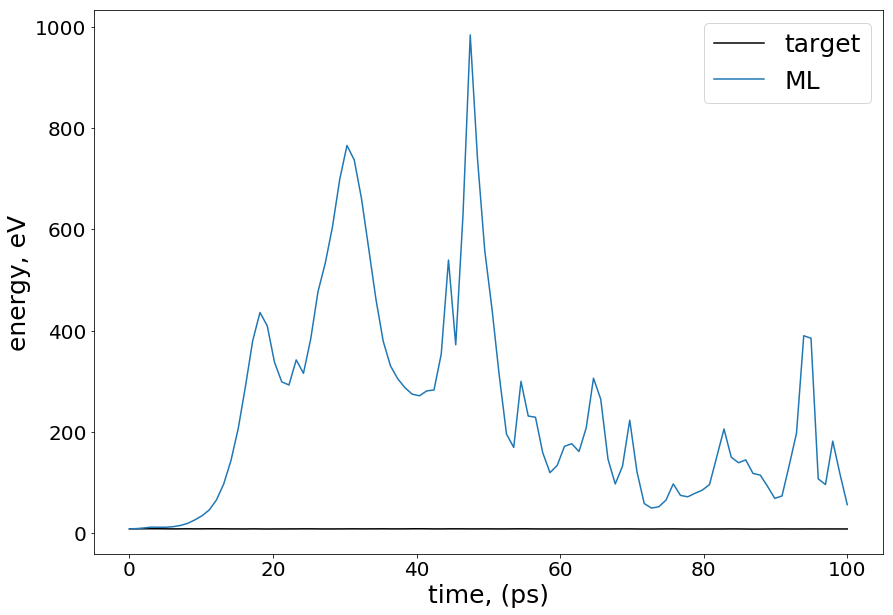

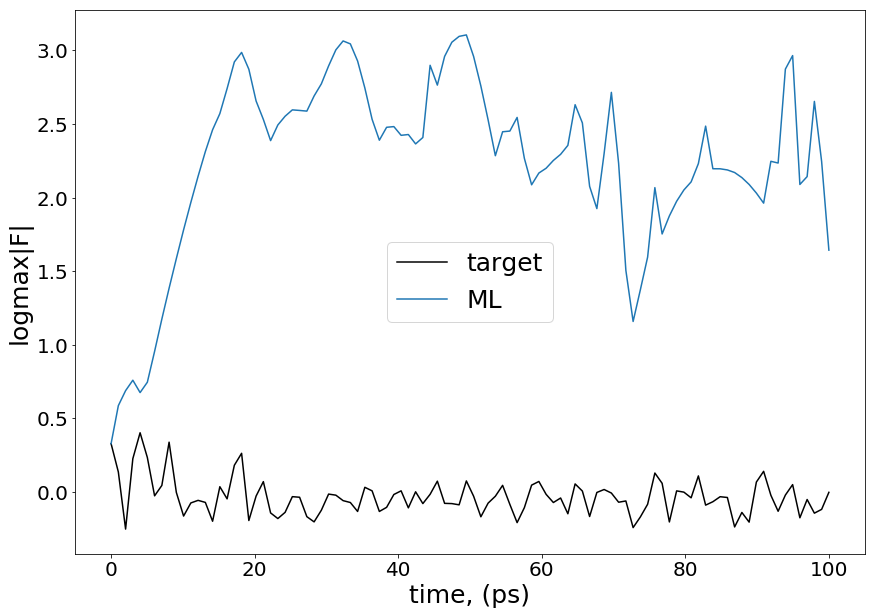

In [40]:
# Time Plots
%matplotlib inline

time_plots(emt_energy, [ml_actual_energy], None, ['ML'], 'energy', None )
time_plots(emt_forces, [ml_actual_forces], None, ['ML'], 'forces', None )

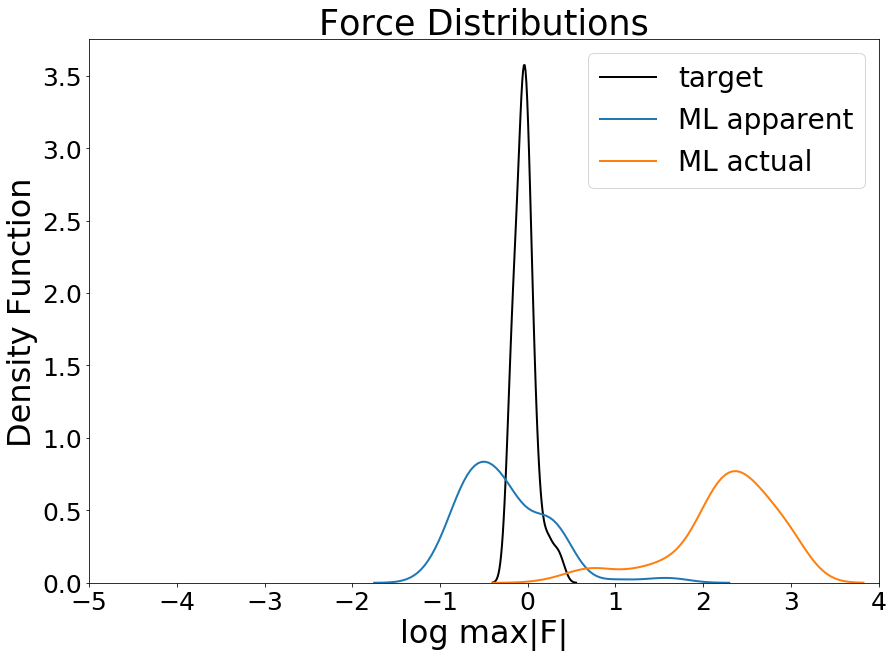

In [41]:
kde_plots(emt_forces, [ml_apparent_forces, ml_actual_forces] , ['ML apparent', 'ML actual'])

In [33]:
# LJ Optimization
def lj_optimization(images, Gs, label):
    cutoff = Gs["cutoff"]
    a=12
    p0 = [
        1.0,
        6.3535,
        0,
        1.0808,
        8.5357,
        0,
        2.1717,
        3.7575,
        0,
        a
    ]
    params_dict = {"C": [], "O": [], "Cu": []}
    lj_model = lj_optim(images, p0, params_dict, cutoff, label)
    fitted_params = lj_model.fit()
    lj_energies, lj_forces, num_atoms = lj_model.lj_pred(
        images, fitted_params, params_dict
    )
    lj_data = [
        lj_energies,
        lj_forces,
        num_atoms,
        fitted_params,
        params_dict,
        lj_model,
    ]
    return lj_data

label_lj = "COCu_LJ_1_300K"
lj_data = lj_optimization(images, Gs, label)
forcetraining = True
training_lj_data = AtomsDataset(images, SNN_Gaussian, Gs, forcetraining=forcetraining,
        label=label, cores=10, lj_data=lj_data)
unique_atoms = training_lj_data.elements
fp_length = training_lj_data.fp_length
scalings = training_lj_data.scalings

LJ optimization initiated...


/home/mshuaibi/Documents/amp_refactoring/amptorch/lj_model.py:112: RuntimeWarning: invalid value encountered in sqrt
  eps = np.sqrt(eps_1 * eps_n)


Optimizer did not terminate successfully.
Calculating fingerprints...
Fingerprints Calculated!


In [34]:
# Define calculator and train
calc_lj = AMP(training_lj_data, net, label=label)
calc_lj.train(overwrite=True)

Re-initializing optimizer.
  epoch    energy_score    forces_score    train_loss    valid_loss    cp     dur
-------  --------------  --------------  ------------  ------------  ----  ------
      1          0.0527          0.2275        0.9146        1.3020     +  0.5742
      2          0.0113          0.2184        0.5816        0.5468     +  0.5560
      3          0.0139          0.2069        0.3857        0.5120     +  0.5508
      4          0.0275          0.2040        0.3025        0.6510     +  0.5907
      5          0.0135          0.2026        0.2805        0.4899     +  0.5537
      6          0.0168          0.2022        0.2695        0.5146     +  0.5528
      7          0.0168          0.2022        0.2632        0.5146        0.5509
      8          0.0200          0.2018        0.2623        0.5449     +  0.5477
      9          0.0173          0.2011        0.2590        0.5155     +  0.5472
     10          0.0194          0.2006        0.2539        0.5337    

     91          0.0185          0.1971        0.1902        0.5089        0.5943
     92          0.0204          0.1950        0.1918        0.5202        0.6958
     93          0.0182          0.1974        0.1853        0.5080        0.5494
     94          0.0120          0.1951        0.1828        0.4475        0.5834
     95          0.0161          0.1968        0.1802        0.4855        0.5328
     96          0.0131          0.1973        0.1725        0.4646        0.8060
     97          0.0131          0.1973        0.1712        0.4646        0.5867
     98          0.0135          0.1975        0.1710        0.4678        0.5654
     99          0.0126          0.1988        0.1727        0.4671        0.5713
    100          0.0126          0.1976        0.1723        0.4623        0.5694
    101          0.0128          0.1991        0.1842        0.4697        0.7232
    102          0.0186          0.1997        0.1761        0.5212        0.5615
    103         

    189          0.0181          0.2077        0.1411        0.5510        0.3888
    190          0.0112          0.2072        0.1441        0.4948        0.4001
    191          0.0189          0.2070        0.1501        0.5566        0.5940
    192          0.0094          0.2081        0.1545        0.4891        0.5416
    193          0.0195          0.2052        0.1567        0.5548        0.4755
    194          0.0159          0.2072        0.1514        0.5293        0.6852
    195          0.0153          0.2068        0.1446        0.5227        0.4885
    196          0.0192          0.2067        0.1422        0.5579        0.6304
    197          0.0192          0.2067        0.1382        0.5579        0.7508
    198          0.0177          0.2066        0.1379        0.5427        0.7038
    199          0.0221          0.2070        0.1415        0.5916        0.7409
    200          0.0209          0.2083        0.1470        0.5833        0.6678
    201         

    288          0.0135          0.2036        0.1211        0.4945        0.6398
    289          0.0147          0.2047        0.1214        0.5082        0.7241
    290          0.0147          0.2045        0.1233        0.5072        0.6689
    291          0.0132          0.2071        0.1233        0.5076        0.7224
    292          0.0120          0.2073        0.1274        0.5007        0.5918
    293          0.0347          0.2106        0.1506        0.8001        0.6319
    294          0.0132          0.2068        0.1569        0.5068        0.6013
    295          0.0154          0.2069        0.1371        0.5235        0.5363
    296          0.0144          0.2075        0.1251        0.5179        0.5854
    297          0.0144          0.2075        0.1228        0.5179        0.5036
    298          0.0154          0.2085        0.1211        0.5307        0.6097
    299          0.0127          0.2088        0.1250        0.5118        0.4465
    300         

    387          0.0134          0.2119        0.1072        0.5304        0.6055
    388          0.0158          0.2120        0.1078        0.5502        0.7346
    389          0.0158          0.2117        0.1086        0.5484        0.6501
    390          0.0175          0.2120        0.1106        0.5648        0.6334
    391          0.0076          0.2106        0.1217        0.4920        0.6038
    392          0.0214          0.2122        0.1400        0.6070        0.7409
    393          0.0128          0.2142        0.1264        0.5368        0.4773
    394          0.0147          0.2092        0.1222        0.5282        0.6406
    395          0.0171          0.2114        0.1175        0.5589        0.6265
    396          0.0148          0.2103        0.1098        0.5341        0.6898
    397          0.0148          0.2103        0.1076        0.5341        0.6356
    398          0.0145          0.2108        0.1086        0.5339        0.6077
    399         

    487          0.0157          0.2178        0.0947        0.5758        0.3325
    488          0.0149          0.2173        0.0952        0.5670        0.3587
    489          0.0151          0.2173        0.0984        0.5682        0.3367
    490          0.0130          0.2150        0.0968        0.5419        0.3509
    491          0.0138          0.2187        0.1039        0.5652        0.5475
    492          0.0241          0.2164        0.1203        0.6590        0.4668
    493          0.0092          0.2142        0.1176        0.5155        0.4948
    494          0.0119          0.2132        0.1156        0.5263        0.3422
    495          0.0177          0.2178        0.1073        0.5935        0.6121
    496          0.0129          0.2163        0.0989        0.5477        0.4288
    497          0.0129          0.2163        0.0963        0.5477        0.6109
    498          0.0118          0.2158        0.0980        0.5379        0.4796
    499         

    587          0.0132          0.2204        0.0878        0.5691        0.6157
    588          0.0159          0.2194        0.0874        0.5848        0.4317
    589          0.0144          0.2202        0.0873        0.5769        0.5017
    590          0.0161          0.2216        0.0886        0.5975        0.3556
    591          0.0091          0.2211        0.0952        0.5479        0.6181
    592          0.0328          0.2243        0.1136        0.8302        0.6255
    593          0.0136          0.2191        0.1374        0.5656        0.6139
    594          0.0150          0.2224        0.1168        0.5915        0.6425
    595          0.0138          0.2208        0.1026        0.5746        0.6421
    596          0.0159          0.2188        0.0923        0.5821        0.4929
    597          0.0159          0.2188        0.0893        0.5821        0.4848
    598          0.0148          0.2191        0.0885        0.5744        0.5951
    599         

    686          0.0191          0.2200        0.0883        0.6177        0.6259
    687          0.0191          0.2200        0.0846        0.6177        0.5994
    688          0.0168          0.2198        0.0888        0.5944        0.6173
    689          0.0196          0.2207        0.0952        0.6265        0.7313
    690          0.0163          0.2220        0.0914        0.6014        0.7405
    691          0.0256          0.2231        0.0867        0.7114        0.6705
    692          0.0157          0.2221        0.0917        0.5964        0.7773
    693          0.0260          0.2237        0.1024        0.7188        0.7411
    694          0.0201          0.2202        0.0965        0.6293        0.4249
    695          0.0206          0.2201        0.0861        0.6343        0.6002
    696          0.0202          0.2198        0.0795        0.6289        0.5943
    697          0.0202          0.2198        0.0772        0.6289        0.5754
    698         

    786          0.0206          0.2201        0.0762        0.6340        0.5951
    787          0.0206          0.2201        0.0735        0.6340        0.5623
    788          0.0216          0.2189        0.0730        0.6406        0.6487
    789          0.0229          0.2183        0.0738        0.6531        0.5646
    790          0.0240          0.2184        0.0739        0.6676        0.5558
    791          0.0233          0.2201        0.0765        0.6665        0.5950
    792          0.0211          0.2174        0.0797        0.6267        0.5634
    793          0.0208          0.2216        0.0813        0.6431        0.6068
    794          0.0236          0.2195        0.0799        0.6675        0.6546
    795          0.0201          0.2206        0.0767        0.6311        0.5779
    796          0.0221          0.2206        0.0735        0.6542        0.7241
    797          0.0221          0.2206        0.0704        0.6542        0.6538
    798         

    886          0.0258          0.2239        0.0666        0.7175        0.6463
    887          0.0258          0.2239        0.0645        0.7175        0.5890
    888          0.0247          0.2242        0.0647        0.7040        0.6385
    889          0.0265          0.2247        0.0654        0.7305        0.6205
    890          0.0259          0.2256        0.0678        0.7267        0.5984
    891          0.0284          0.2246        0.0701        0.7579        0.5277
    892          0.0343          0.2247        0.0742        0.8592        0.6217
    893          0.0231          0.2251        0.0857        0.6882        0.5973
    894          0.0189          0.2251        0.0839        0.6399        0.5430
    895          0.0254          0.2246        0.0792        0.7155        0.6378
    896          0.0253          0.2246        0.0685        0.7142        0.4875
    897          0.0253          0.2246        0.0660        0.7142        0.7022
    898         

    986          0.0293          0.2245        0.0681        0.7718        0.4622
    987          0.0293          0.2245        0.0624        0.7718        0.5550
    988          0.0311          0.2240        0.0637        0.7988        0.6152
    989          0.0273          0.2241        0.0641        0.7396        0.5405
    990          0.0254          0.2241        0.0641        0.7122        0.5971
    991          0.0324          0.2233        0.0673        0.8175        0.6038
    992          0.0239          0.2266        0.0739        0.7055        0.6021
    993          0.0297          0.2223        0.0836        0.7680        0.6474
    994          0.0157          0.2219        0.0908        0.5948        0.6092
    995          0.0333          0.2222        0.0880        0.8285        0.6201
    996          0.0254          0.2221        0.0733        0.7035        0.6071
    997          0.0254          0.2221        0.0698        0.7035        0.4986
    998         

   1086          0.0303          0.2282        0.0603        0.8060        0.6789
   1087          0.0303          0.2282        0.0581        0.8060        0.8274
   1088          0.0327          0.2282        0.0601        0.8466        0.7240
   1089          0.0281          0.2284        0.0587        0.7722        0.5364
   1090          0.0273          0.2289        0.0597        0.7628        0.5629
   1091          0.0291          0.2290        0.0614        0.7918        0.6158
   1092          0.0366          0.2271        0.0665        0.9145        0.6481
   1093          0.0226          0.2273        0.0745        0.6923        0.6605
   1094          0.0283          0.2283        0.0784        0.7757        0.5909
   1095          0.0293          0.2276        0.0688        0.7863        0.5773
   1096          0.0294          0.2280        0.0623        0.7900        0.5819
   1097          0.0294          0.2280        0.0579        0.7900        0.5140
   1098         

   1186          0.0296          0.2280        0.0596        0.7940        0.6119
   1187          0.0296          0.2280        0.0563        0.7940        0.6651
   1188          0.0289          0.2287        0.0577        0.7870        0.6778
   1189          0.0298          0.2296        0.0593        0.8045        0.6387
   1190          0.0327          0.2298        0.0601        0.8541        0.5316
   1191          0.0327          0.2315        0.0647        0.8628        0.7272
   1192          0.0374          0.2315        0.0697        0.9505        0.7387
   1193          0.0366          0.2296        0.0874        0.9262        0.7738
   1194          0.0327          0.2327        0.0888        0.8692        0.6575
   1195          0.0311          0.2318        0.0737        0.8376        0.9412
   1196          0.0294          0.2318        0.0622        0.8096        0.6571
   1197          0.0294          0.2318        0.0581        0.8096        0.9503
   1198         

   1286          0.0292          0.2326        0.0529        0.8105        0.3487
   1287          0.0292          0.2326        0.0504        0.8105        0.3522
   1288          0.0297          0.2325        0.0501        0.8182        0.3464
   1289          0.0314          0.2330        0.0505        0.8487        0.3420
   1290          0.0320          0.2331        0.0514        0.8583        0.6424
   1291          0.0319          0.2336        0.0544        0.8595        0.5943
   1292          0.0323          0.2346        0.0596        0.8716        0.8073
   1293          0.0303          0.2323        0.0694        0.8268        0.6465
   1294          0.0306          0.2316        0.0713        0.8282        0.5845
   1295          0.0321          0.2332        0.0630        0.8612        0.6033
   1296          0.0305          0.2321        0.0551        0.8287        0.5796
   1297          0.0305          0.2321        0.0522        0.8287        0.6091
   1298         

   1386          0.0277          0.2344        0.0557        0.7964        0.6609
   1387          0.0277          0.2344        0.0525        0.7964        0.6905
   1388          0.0261          0.2349        0.0535        0.7758        0.6548
   1389          0.0292          0.2354        0.0537        0.8243        0.8286
   1390          0.0327          0.2340        0.0551        0.8749        0.7495
   1391          0.0322          0.2354        0.0832        0.8739        0.6730
   1392          0.0341          0.2393        0.0893        0.9274        0.7005
   1393          0.0340          0.2352        0.0914        0.9050        0.7773
   1394          0.0340          0.2347        0.0835        0.9021        0.7957
   1395          0.0321          0.2361        0.0692        0.8750        0.7014
   1396          0.0319          0.2344        0.0576        0.8644        0.7342
   1397          0.0319          0.2344        0.0543        0.8644        0.9823
   1398         

   1486          0.0317          0.2347        0.0563        0.8609        0.5469
   1487          0.0317          0.2347        0.0517        0.8609        0.5626
   1488          0.0343          0.2366        0.0518        0.9167        0.5513
   1489          0.0337          0.2387        0.0519        0.9176        0.5529
   1490          0.0317          0.2354        0.0513        0.8651        0.5591
   1491          0.0295          0.2373        0.0585        0.8383        0.5544
   1492          0.0325          0.2378        0.0637        0.8910        0.5489
   1493          0.0297          0.2337        0.0641        0.8243        0.3129
   1494          0.0310          0.2345        0.0619        0.8495        0.3047
   1495          0.0296          0.2355        0.0549        0.8319        0.3241
   1496          0.0303          0.2347        0.0499        0.8385        0.3263
   1497          0.0303          0.2347        0.0471        0.8385        0.3185
   1498         

   1586          0.0300          0.2350        0.0503        0.8342        0.5411
   1587          0.0300          0.2350        0.0453        0.8342        0.5473
   1588          0.0291          0.2350        0.0442        0.8213        0.5429
   1589          0.0293          0.2352        0.0442        0.8245        0.5650
   1590          0.0292          0.2361        0.0455        0.8281        0.6398
   1591          0.0296          0.2371        0.0507        0.8395        0.5457
   1592          0.0321          0.2378        0.0584        0.8843        0.5609
   1593          0.0228          0.2427        0.0629        0.7722        0.4470
   1594          0.0301          0.2438        0.0591        0.8825        0.6037
   1595          0.0295          0.2416        0.0515        0.8604        0.5761
   1596          0.0290          0.2400        0.0474        0.8444        0.7228
   1597          0.0290          0.2400        0.0442        0.8444        0.5505
   1598         

   1686          0.0293          0.2378        0.0453        0.8385        0.5847
   1687          0.0293          0.2378        0.0426        0.8385        0.5414
   1688          0.0292          0.2392        0.0419        0.8436        0.5528
   1689          0.0295          0.2380        0.0417        0.8422        0.5436
   1690          0.0292          0.2422        0.0424        0.8589        0.6056
   1691          0.0266          0.2416        0.0454        0.8179        0.5246
   1692          0.0321          0.2395        0.0612        0.8936        0.2978
   1693          0.0204          0.2379        0.0703        0.7205        0.2979
   1694          0.0270          0.2414        0.0715        0.8222        0.2991
   1695          0.0296          0.2383        0.0640        0.8456        0.2991
   1696          0.0261          0.2378        0.0510        0.7904        0.4482
   1697          0.0261          0.2378        0.0462        0.7904        0.5371
   1698         

   1786          0.0281          0.2391        0.0449        0.8259        0.5385
   1787          0.0281          0.2391        0.0418        0.8259        0.5521
   1788          0.0291          0.2401        0.0415        0.8477        0.6036
   1789          0.0267          0.2420        0.0413        0.8203        0.5558
   1790          0.0309          0.2415        0.0418        0.8825        0.6114
   1791          0.0246          0.2428        0.0451        0.7967        0.5672
   1792          0.0302          0.2423        0.0553        0.8757        0.5751
   1793          0.0246          0.2418        0.0575        0.7911        0.5604
   1794          0.0314          0.2403        0.0541        0.8847        0.5699
   1795          0.0253          0.2403        0.0492        0.7920        0.5912
   1796          0.0263          0.2402        0.0438        0.8061        0.5740
   1797          0.0263          0.2402        0.0410        0.8061        0.5735
   1798         

   1886          0.0274          0.2425        0.0416        0.8338        0.5414
   1887          0.0274          0.2425        0.0400        0.8338        0.2960
   1888          0.0274          0.2420        0.0392        0.8313        0.4902
   1889          0.0297          0.2412        0.0396        0.8624        0.4320
   1890          0.0293          0.2415        0.0399        0.8573        0.2947
   1891          0.0290          0.2424        0.0424        0.8573        0.2933
   1892          0.0351          0.2425        0.0503        0.9621        0.2972
   1893          0.0282          0.2449        0.0524        0.8581        0.2964
   1894          0.0277          0.2408        0.0501        0.8293        0.3149
   1895          0.0281          0.2430        0.0458        0.8469        0.2930
   1896          0.0267          0.2434        0.0419        0.8288        0.3045
   1897          0.0267          0.2434        0.0390        0.8288        0.2963
   1898         

   1986          0.0234          0.2366        0.0415        0.7487        0.5521
   1987          0.0234          0.2366        0.0396        0.7487        0.5563
   1988          0.0250          0.2366        0.0389        0.7694        0.5398
   1989          0.0238          0.2377        0.0391        0.7590        0.5473
   1990          0.0239          0.2391        0.0406        0.7679        0.5411
   1991          0.0249          0.2400        0.0432        0.7857        0.5413
   1992          0.0299          0.2384        0.0489        0.8504        0.5433
   1993          0.0192          0.2425        0.0616        0.7307        0.5501
   1994          0.0202          0.2392        0.0661        0.7249        0.5408
   1995          0.0240          0.2391        0.0545        0.7691        0.5438
   1996          0.0223          0.2399        0.0446        0.7522        0.5428
   1997          0.0223          0.2399        0.0421        0.7522        0.5469
   1998         

In [35]:
# MLMD Simulation
md_run(calc=calc_lj, starting_image=images[0].copy(), temp=300, count=2000, label=label_lj, ensemble='langevin')

Energy per atom: Epot = 0.265eV Ekin = 0.012eV (T= 95K) Etot = 0.277eV
Energy per atom: Epot = 0.267eV Ekin = 0.011eV (T= 86K) Etot = 0.278eV
Energy per atom: Epot = 0.271eV Ekin = 0.010eV (T= 80K) Etot = 0.281eV
Energy per atom: Epot = 0.276eV Ekin = 0.009eV (T= 73K) Etot = 0.285eV
Energy per atom: Epot = 0.277eV Ekin = 0.007eV (T= 57K) Etot = 0.284eV
Energy per atom: Epot = 0.275eV Ekin = 0.005eV (T= 41K) Etot = 0.280eV
Energy per atom: Epot = 0.273eV Ekin = 0.003eV (T= 26K) Etot = 0.276eV
Energy per atom: Epot = 0.274eV Ekin = 0.003eV (T= 26K) Etot = 0.278eV
Energy per atom: Epot = 0.278eV Ekin = 0.004eV (T= 31K) Etot = 0.282eV
Energy per atom: Epot = 0.279eV Ekin = 0.004eV (T= 33K) Etot = 0.284eV
Energy per atom: Epot = 0.279eV Ekin = 0.005eV (T= 39K) Etot = 0.284eV
Energy per atom: Epot = 0.278eV Ekin = 0.006eV (T= 46K) Etot = 0.284eV
Energy per atom: Epot = 0.277eV Ekin = 0.007eV (T= 55K) Etot = 0.284eV
Energy per atom: Epot = 0.278eV Ekin = 0.008eV (T= 65K) Etot = 0.286eV
Energy

Energy per atom: Epot = 0.284eV Ekin = 0.018eV (T=137K) Etot = 0.302eV
Energy per atom: Epot = 0.281eV Ekin = 0.017eV (T=130K) Etot = 0.297eV
Energy per atom: Epot = 0.283eV Ekin = 0.013eV (T= 98K) Etot = 0.296eV
Energy per atom: Epot = 0.281eV Ekin = 0.015eV (T=113K) Etot = 0.296eV
Energy per atom: Epot = 0.281eV Ekin = 0.016eV (T=125K) Etot = 0.297eV
Energy per atom: Epot = 0.285eV Ekin = 0.016eV (T=124K) Etot = 0.301eV
Energy per atom: Epot = 0.289eV Ekin = 0.016eV (T=123K) Etot = 0.305eV
Energy per atom: Epot = 0.292eV Ekin = 0.013eV (T= 97K) Etot = 0.305eV
Energy per atom: Epot = 0.289eV Ekin = 0.017eV (T=131K) Etot = 0.306eV
Energy per atom: Epot = 0.288eV Ekin = 0.018eV (T=138K) Etot = 0.306eV
Energy per atom: Epot = 0.288eV Ekin = 0.017eV (T=133K) Etot = 0.305eV
Energy per atom: Epot = 0.290eV Ekin = 0.016eV (T=125K) Etot = 0.306eV
Energy per atom: Epot = 0.290eV Ekin = 0.014eV (T=108K) Etot = 0.304eV
Energy per atom: Epot = 0.287eV Ekin = 0.016eV (T=124K) Etot = 0.303eV
Energy

In [36]:
# Calculate forces of base and generated trajectory
mllj_images = ase.io.read(label_lj+".traj", ":")
emt_energy, mllj_apparent_energy, mllj_actual_energy = calculate_energies(images, mllj_images[:2000:20])
emt_forces, mllj_apparent_forces, mllj_actual_forces = calculate_forces(images, mllj_images[:2000:20], type="max")


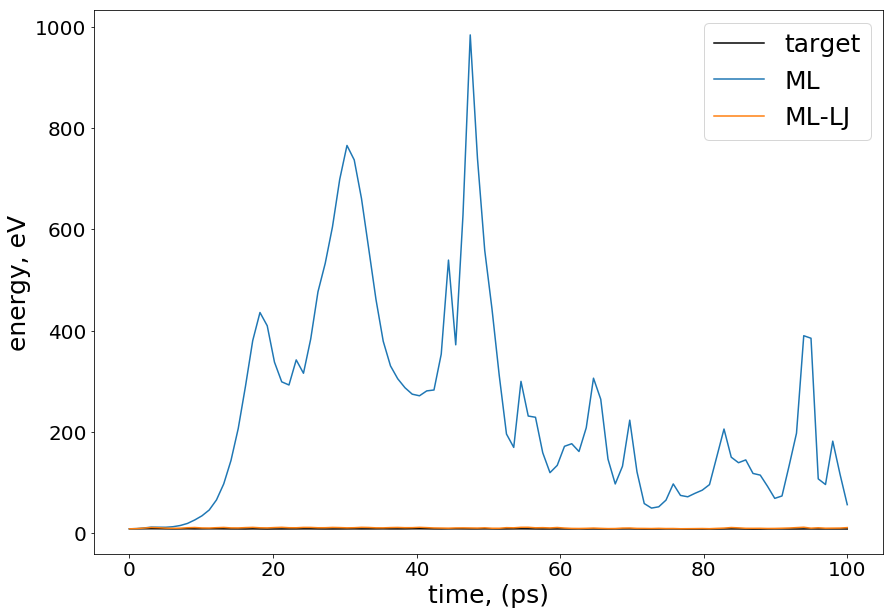

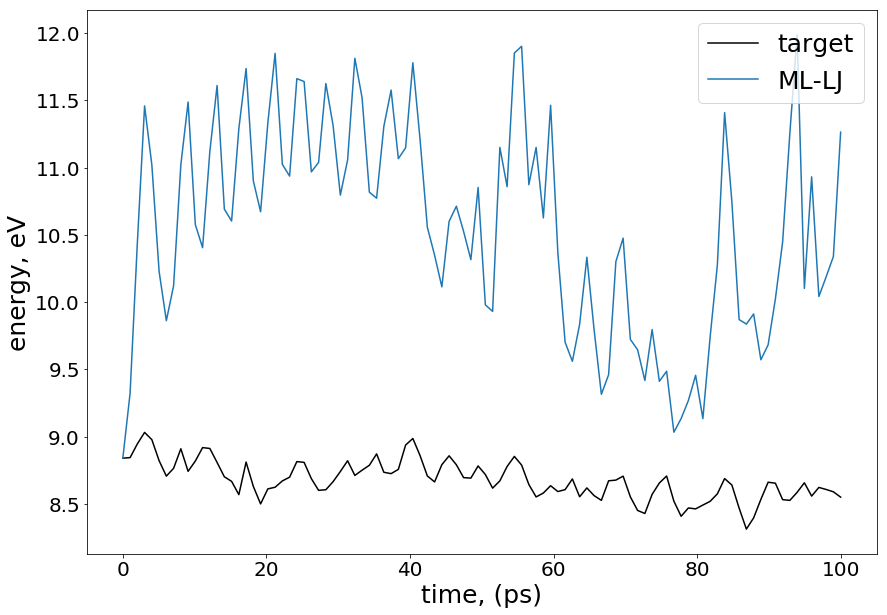

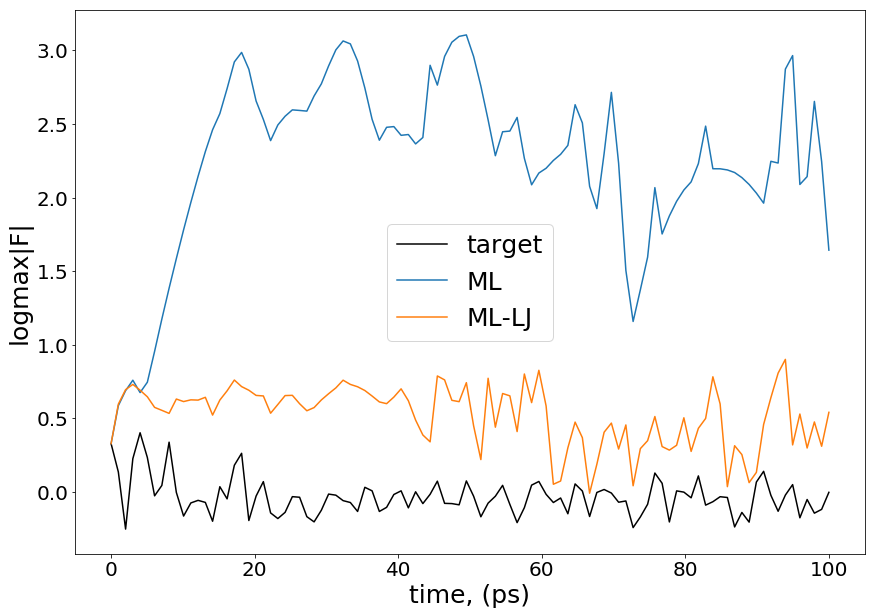

In [43]:
# Time Plots
%matplotlib inline

time_plots(emt_energy, [ml_actual_energy, mllj_actual_energy], None, ['ML', 'ML-LJ'], 'energy', None )
time_plots(emt_energy, [mllj_actual_energy], None, ['ML-LJ'], 'energy', None )
time_plots(emt_forces, [ml_actual_forces, mllj_actual_forces], None, ['ML', 'ML-LJ'], 'forces', None )

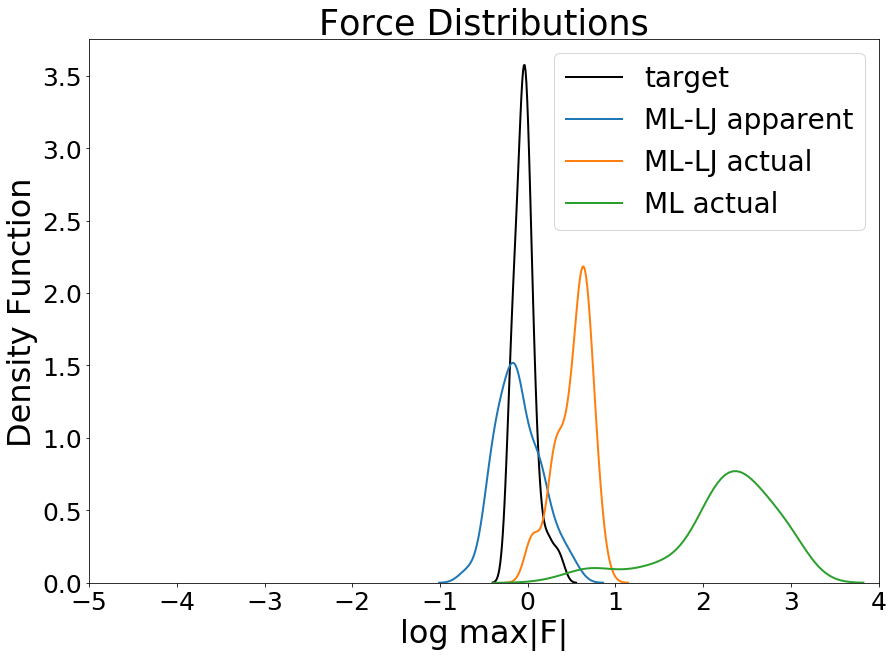

In [38]:
kde_plots(emt_forces, [mllj_apparent_forces, mllj_actual_forces, ml_actual_forces] , ['ML-LJ apparent', 'ML-LJ actual', 'ML actual'])